# Sentiment Analysis on Twitter Data (Sentiment140 Dataset)

This notebook demonstrates sentiment classification on Twitter text using the **Sentiment140 dataset** (1.6M tweets).  
The goal is to build a reproducible baseline pipeline for text preprocessing, feature extraction, and machine learning classification.

---

## 🔹 Pipeline Overview
1. **Load Data**  
   - Auto-detect Kaggle dataset (Sentiment140)  
   - Fallback: load from local `data/sentiment.csv` (with columns `text`, `label`)

2. **Preprocessing & Cleaning**  
   - Remove URLs, @user mentions, hashtags  
   - Strip punctuation and extra whitespace  
   - Convert text to lowercase

3. **Dataset Split**  
   - Train/validation split for model evaluation  

4. **Feature Engineering**  
   - Apply **TF-IDF vectorization** (unigrams + bigrams)  

5. **Model Training**  
   - Naive Bayes  
   - Logistic Regression  

6. **Evaluation**  
   - Accuracy, Precision, Recall, F1-score  
   - Confusion Matrix (saved to `plots/confusion_matrix.png`)  
   - ROC-AUC  

7. **Model Persistence**  
   - Save best-performing model and TF-IDF vectorizer for reuse  

---

📌 **Note**:  
The full Sentiment140 dataset is large (1.6M tweets). For demonstration, a smaller subsample may be used in this notebook.  
Please download the complete dataset from [Kaggle Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140) if you wish to reproduce the full-scale experiments.


In [1]:
# Environment & libraries
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score
)

# Ensure output folders exist
os.makedirs("plots", exist_ok=True)
os.makedirs("data", exist_ok=True)

print("Setup complete. Working directory:", os.getcwd())


Setup complete. Working directory: /kaggle/working


In [2]:
# === Auto-detect + Load Sentiment140 + (Optional) Sampling + Cleaning ===
# Priority: Kaggle input folders → local file next to the notebook
candidates = [
    "/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",
    "/kaggle/input/training160m/training.1600000.processed.noemoticon.csv",
    "training.1600000.processed.noemoticon.csv",  # local/Colab same folder
]

csv_path = next((p for p in candidates if os.path.exists(p)), None)
if csv_path is None:
    print("Mounted under /kaggle/input:", os.listdir("/kaggle/input") if os.path.isdir("/kaggle/input") else "N/A")
    raise FileNotFoundError("Sentiment140 CSV not found. Add the dataset in Kaggle or place the file next to this notebook.")

print("Using file:", csv_path)

# Sentiment140: latin-1, no header
df = pd.read_csv(
    csv_path,
    encoding="latin-1",
    header=None,
    names=["target","ids","date","flag","user","text"]
)[["text","target"]]

# Map labels (0→negative, 4→positive)
df["label"] = df["target"].map({0: "negative", 4: "positive"})
df = df[["text","label"]].dropna().reset_index(drop=True)
print("Original dataset:", df.shape)
print(df["label"].value_counts())

# (Optional) Subsample for faster iteration. Set to None for full 1.6M rows.
sample_size = 50_000  # change to None for full dataset
if sample_size is not None and sample_size < len(df):
    df = df.sample(sample_size, random_state=42).reset_index(drop=True)
print("Working dataset:", df.shape)
print(df["label"].value_counts())

# Basic text cleaning
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+|www\S+", " ", s)   # URLs
    s = re.sub(r"@[A-Za-z0-9_]+", " ", s)  # @mentions
    s = re.sub(r"#\S+", " ", s)            # hashtags
    s = re.sub(r"[^a-z0-9\s]", " ", s)     # keep alnum + spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["text"] = df["text"].astype(str).apply(clean_text)
df = df[df["text"].str.len() > 0].reset_index(drop=True)
print("After cleaning:", df.shape)

# Save a cleaned copy for reuse
df.to_csv("data/sentiment.csv", index=False)
print("Saved cleaned dataset → data/sentiment.csv")

# Preview
df.head(3)


Using file: /kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
Original dataset: (1600000, 2)
label
negative    800000
positive    800000
Name: count, dtype: int64
Working dataset: (50000, 2)
label
positive    25014
negative    24986
Name: count, dtype: int64
After cleaning: (49878, 2)
Saved cleaned dataset → data/sentiment.csv


,text,label
0,ahhh i hope your ok,negative
1,cool i have no tweet apps for my razr 2,negative
2,i know just family drama its lame hey next tim...,negative


In [3]:
X = df["text"]
y = df["label"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF with unigrams + bigrams; adjust max_features for RAM/speed
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=200_000,   # try 20_000 if RAM is limited
    ngram_range=(1, 2),
    min_df=2
)

X_train_vec = vectorizer.fit_transform(X_train)
X_valid_vec = vectorizer.transform(X_valid)

X_train_vec.shape, X_valid_vec.shape


((39902, 29544), (9976, 29544))

In [4]:
models = {
    "NaiveBayes": MultinomialNB(),
    "LogReg": LogisticRegression(max_iter=2000, n_jobs=None)
}

metrics = {}
reports = {}
pred_store = {}

for name, model in models.items():
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_valid_vec)
    pred_store[name] = preds
    acc = accuracy_score(y_valid, preds)
    metrics[name] = acc
    reports[name] = classification_report(y_valid, preds, digits=4, zero_division=0)
    print(f"[{name}] Accuracy = {acc:.4f}")
    print(reports[name])

best_name = max(metrics, key=metrics.get)
best_model = models[best_name]
best_preds = pred_store[best_name]
print("Best model:", best_name, "Accuracy:", metrics[best_name])


[NaiveBayes] Accuracy = 0.7378
              precision    recall  f1-score   support

    negative     0.7365    0.7404    0.7385      4988
    positive     0.7390    0.7352    0.7371      4988

    accuracy                         0.7378      9976
   macro avg     0.7378    0.7378    0.7378      9976
weighted avg     0.7378    0.7378    0.7378      9976

[LogReg] Accuracy = 0.7477
              precision    recall  f1-score   support

    negative     0.7544    0.7346    0.7443      4988
    positive     0.7414    0.7608    0.7510      4988

    accuracy                         0.7477      9976
   macro avg     0.7479    0.7477    0.7477      9976
weighted avg     0.7479    0.7477    0.7477      9976

Best model: LogReg Accuracy: 0.7476944667201283


In [5]:
# Works for binary sentiment (negative vs positive).
# For ROC-AUC, we need probabilities. Prefer Logistic Regression if available.
try:
    if "LogReg" in models:
        probs = models["LogReg"].predict_proba(X_valid_vec)[:, 1]
    else:
        probs = best_model.predict_proba(X_valid_vec)[:, 1]

    # Map labels to {0,1}: negative→0, positive→1
    y_valid_bin = (y_valid == "positive").astype(int)
    auc = roc_auc_score(y_valid_bin, probs)
    print("ROC-AUC:", round(auc, 4))
except Exception as e:
    print("ROC-AUC not computed:", e)


ROC-AUC: 0.826


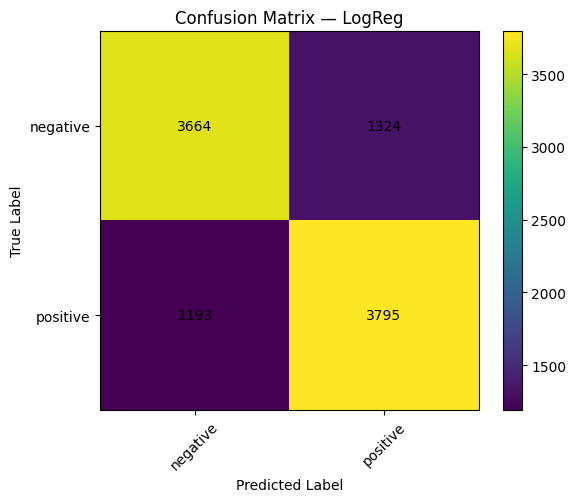

Saved plot → plots/confusion_matrix.png


In [6]:
labels = sorted(y_valid.unique())
cm = confusion_matrix(y_valid, best_preds, labels=labels)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title(f'Confusion Matrix — {best_name}')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
out_path = "plots/confusion_matrix.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved plot → {out_path}")


In [7]:
examples = [
    "I absolutely love this product!",
    "Worst experience ever. Totally disappointed.",
    "Not bad, could be better."
]

for text in examples:
    vec = vectorizer.transform([text])
    pred = best_model.predict(vec)[0]
    print(f"Text: {text}  =>  Predicted: {pred}")


Text: I absolutely love this product!  =>  Predicted: positive
Text: Worst experience ever. Totally disappointed.  =>  Predicted: negative
Text: Not bad, could be better.  =>  Predicted: negative


In [8]:
import pickle

with open("sentiment140_best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

with open("sentiment140_tfidf.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("Saved: sentiment140_best_model.pkl, sentiment140_tfidf.pkl")


Saved: sentiment140_best_model.pkl, sentiment140_tfidf.pkl


In [9]:
summary = {
    "best_model": best_name,
    "accuracy": round(metrics[best_name], 4),
    "n_train": X_train_vec.shape[0],
    "n_valid": X_valid_vec.shape[0],
    "tfidf_max_features": vectorizer.max_features,
    "tfidf_ngram_range": vectorizer.ngram_range
}
try:
    summary["roc_auc"] = round(roc_auc_score((y_valid=="positive").astype(int),
                                             models.get("LogReg", best_model).predict_proba(X_valid_vec)[:,1]), 4)
except Exception:
    pass

pd.Series(summary)


best_model            LogReg
accuracy              0.7477
n_train                39902
n_valid                 9976
tfidf_max_features    200000
tfidf_ngram_range     (1, 2)
roc_auc                0.826
dtype: object